In [1]:
import pandas as pd
import re
import itertools
import numpy as np
import pickle
import os

In [2]:
import requests
from nltk.tokenize import word_tokenize
from gensim.utils import simple_preprocess
from gensim import corpora
from nltk.corpus import stopwords
from time import time

In [3]:
from ua_parser import user_agent_parser
from gensim.models.fasttext import FastText
import collections
import math
from sklearn import preprocessing
import ipinfo
import category_encoders as ce

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import Birch, DBSCAN, OPTICS, AgglomerativeClustering, AffinityPropagation
from sklearn.cluster import MiniBatchKMeans, SpectralClustering, KMeans, SpectralCoclustering
from sklearn.model_selection import train_test_split
from collections import Counter
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [5]:
#Обработка данных
def get_stats():
    return requests.get('https://slot-ml.com/api/v1/users/4e5bd33034c6cf34acd47a679ed113f367c21d1c/stats').json()
    
def get_data():
    return requests.get('https://slot-ml.com/api/v1/users/4e5bd33034c6cf34acd47a679ed113f367c21d1c/vectors/?random').json()
    
def load_and_save_data(n_range):
    for i in range(n_range):
        data.loc[data.shape[0], :] = get_data()
    data.to_csv('data.csv')
    
def create_empty_data():
    return pd.DataFrame({'meta1': pd.Series(dtype='str'),
                         'id': pd.Series(dtype='str'),
                        'meta2': pd.Series(dtype='str'),
                        'vector': pd.Series(dtype='str'),
                        'meta3': pd.Series(dtype='int'),
                        'meta6': pd.Series(dtype='str'),
                        'meta4': pd.Series(dtype='int'),
                        'meta5': pd.Series(dtype='str'),
                        }
                       )    

def save_pickle(file, name):
    """Util for saving pickle-files"""
    with open(os.path.join('data/', name + '.pickle'), 'wb') as f:
        pickle.dump(file, f)

### День первый: глаза боятся, а руки делают
<p>Итак, в задаче сказано: написать классификатор, позволяющий разграничить данные на условно безопасные и потенциально опасные. Поскольку задачи на кибератаки мне раньше не встречались, я решила провести детальный разведывательный анализ поступающей от генератора информации. Гугл и отдельные статьи позволили вывести несколько правил:
    <ul>
      <li>Прямые обращения к БД и управляющим файлам выглядят подозрительно,</li>
      <li>Как и множественные запросы с одного ip.</li>
      <li>Распределение meta4 - назовём его весом - имеет тяжёлый правый хвост, очень подозрительно, баним.</li>
      <li>User-agent, содержащий подозрительные слова, не связанные с браузерами, контролировать.</li> 
      <li> С другой стороны: поисковые боты и сканеры уязвимостей имеют очень подозрительное поведение, однако вредоносными не являются. Поэтому, их стоит попробовать исключить из потенциальных опасностей.</li>
    </ul>
Итогом обнаруженных правил первого и второго дня стал <b>Watchman</b>, класс, позволяющий обнаружить 20-30% вредоносных действий. С его помощью можно было бы построить примитивный классификатор и, активным обучением, попробовать доразметить ещё сколько-то данных для последующего обучения полноценного классификатора.
</p>

In [6]:
class Watchman():
    def __init__(self, data):
        self.df = data.copy()
        self.white_list = ['arachni', 'nikto', 'openvas', 'acunetix']
        self._preprocess()
        
    def _preprocess(self):        
        self.df['meta4'] = self.df['meta4'].astype(int)
        self.df['meta3'] = self.df['meta3'].astype(int)        
        self.df = self.df.fillna('')
        self.df['vector'] = self.df.vector.str.lower()   
        self.df['meta5'] = self.df.meta5.str.lower()
        for idx, row in self.df.iterrows():
            self.df.loc[idx, 'meta2'] = self.df.loc[idx, 'meta2'].replace(self.df.loc[idx, 'meta1']+'.', '' ) 
        self.df['len_meta2'] = self.df['meta2'].apply(len)
        
    def white_list(func):
        def wrapper(self, *args, **kwargs):
            #Дать разрешение внутренним дружелюбным ботам. Arachni, Nikto, OpenVAS 
            black_list_edt = []           
            for one_id in func(self, *args, **kwargs):
                res = [1 for one_word in self.white_list if
                       self.df.loc[self.df.id==one_id, 'meta5'].str.contains(one_word).any() | 
                       self.df.loc[self.df.id==one_id, 'vector'].str.contains(one_word).any()]
                
                if sum(res)==0:
                    black_list_edt.append(one_id)
            return black_list_edt  
        return wrapper
    
    @white_list
    def get_bl_by_request_stops(self):
        black_list = []
        black_words = ['windows', 'ini', 'net', 'select', 'delete',
                       'update', 'password', ' or ']
        for one_word in black_words:
            l = self.df.loc[self.df.vector.str.contains(one_word), 'id'].to_list()           
            black_list.extend(self.df.loc[self.df.vector.str.contains(one_word), 'id'].to_list())
        return black_list
    
    
    @white_list
    def get_bl_by_data_volume(self, q=0.95):
        return self.df.loc[self.df.meta4>=self.df.meta4.quantile(q=q), 'id'].to_list()
    
    @white_list
    def get_bl_by_request_frequency(self, threshold=3):        
        black_ip = self.df.meta6.value_counts()[self.df.meta6.value_counts()>threshold].index.to_list()
        return self.df.loc[self.df.meta6.isin(black_ip), 'id'].to_list()
    
    @white_list
    def get_bl_by_user_agent_stops(self):
        black_list = []
        black_words = ['apache-httpclient', 'python', 'winhttprequest']
        for one_word in black_words:
            black_list.extend(self.df.loc[self.df.meta5.str.contains(one_word), 'id'].to_list())
        return black_list  
    
    @white_list
    def get_bl_by_user_agent_frequency(self, threshold=0.05):
        white_words = ['arachni', 'openvas', 'mozilla', 'ucweb', 'ucbrowser',
                      'firefox', 'chrome', 'safari']
        vecs = self.df['meta5'].apply(simple_preprocess)
        dictionary = corpora.Dictionary(vecs)
        rare_ids = [key for key, value in dictionary.dfs.items() if value<round(self.df.shape[0]*threshold)]
        dictionary.filter_tokens(rare_ids)
        dictionary.add_documents([white_words])
        self.df['meta5_cls'] = [dictionary.doc2bow(one_vec) for one_vec in vecs]        
        return self.df.loc[self.df['meta5_cls'].apply(lambda x: len(x)==0), 'id'].to_list()
    
    
    @white_list
    def get_bl_by_request_meta_regex(self):
        black_list = []
        sliced_df = self.df.loc[(self.df.meta1=='REQUEST_HEADERS')&
                                (self.df.meta2=='Referer')]        
        black_list.extend(sliced_df.loc[sliced_df.vector.str.contains('file'), 'id'].to_list())
        
        sliced_df = self.df.loc[(self.df.meta1=='REQUEST_HEADERS')&
                                (self.df.meta2=='Connection')]        
        black_list.extend(sliced_df.loc[~sliced_df.vector.str.contains('close|alive', regex=True), 'id'].to_list()) 
        
        sliced_df = self.df.loc[(self.df.meta1=='REQUEST_HEADERS')&
                                (self.df.meta2=='Connection')]        
        black_list.extend(sliced_df.loc[~sliced_df.vector.str.contains('close|alive', regex=True), 'id'].to_list())  
        
        sliced_df = self.df.loc[(self.df.meta1=='REQUEST_HEADERS')&
                        (self.df.meta2=='X-Forwarded-For')]        
        black_list.extend(sliced_df.loc[sliced_df.vector.str.contains('[^a-z0-9.:]', regex=True), 'id'].to_list())        
        return black_list
    
    @white_list
    def get_bl_by_request_meta_frequency(self, q=0.95):
        sliced_df = self.df.loc[(self.df.meta1.isin(['REQUEST_POST_ARGS',
                                                     'REQUEST_GET_ARGS', 'REQUEST_COOKIES',
                                                     'RESPONSE_HEADERS', 'REQUEST_HEADERS']))]         
        return sliced_df.loc[sliced_df.len_meta2>=self.df.len_meta2.quantile(q=q), 'id'].to_list()
    
    @white_list
    def get_bl_full_rules(self, q=0.95, threshold_request=3,
                         threshold_user_agent=0.05):
        black_list = []
        black_list.extend(self.get_bl_by_request_stops())
        black_list.extend(self.get_bl_by_data_volume(q))
        black_list.extend(self.get_bl_by_request_frequency(threshold_request))
        black_list.extend(self.get_bl_by_user_agent_stops())
        black_list.extend(self.get_bl_by_request_meta_regex())
        black_list.extend(self.get_bl_by_request_meta_frequency(q))
               
        black_ip = self.df.loc[self.df.id.isin(black_list), 'meta6']
        black_list.extend(self.df.loc[self.df.meta6.isin(black_ip), 'id'].to_list())
        return set(black_list)
        
    def get_wt_list(self):
        white_list_edt = []           
        for one_id in self.df.id:
            res = [1 for one_word in self.white_list if
                   self.df.loc[self.df.id==one_id, 'meta5'].str.contains(one_word).any() | 
                   self.df.loc[self.df.id==one_id, 'vector'].str.contains(one_word).any()]

            if sum(res)>0:
                white_list_edt.append(one_id)
        return white_list_edt  
        
    

### День второй: как съесть слона?

Очевидная информация была проанализирована, но куча колонок всё ещё остаётся не у дел, нужно копать глубже. Что такое meta1 и meta2? Какая польза от ip? Что можно получить из ответа сервера, но он, хотя бы числовой, пусть пока полежит нетронутым.
<ul>
    <li><b>meta5</b>. Первой мыслью было векторизовать его банальным мешком слов, чтобы удалить самые редкие, то есть потенциально подозрительные слова, но эта идея прироста точности не дала. Поэтому воспользовалась парсером user-agent, чтобы разобрать на ключевые слова. В тестах использую только часть фич, при увеличении размера датасета всегда можно включить оставшиеся.</li>
    <li><b>meta6</b>. С ip можно сотворить разное: можно бинаризовать внешний/внутренний, можно банально убрать точки/двоеточия и перевести в число, можно ip4 разбить на разряды, остальное объявить выбросами. Мне понравилась идея распарсить сторонней библиотекой ipinfo и использовать часть информации (страна, компания и тд.). Здесь также было бы полезно добавить поиск по базам "чёрных" ip, но нет уверенности, что генератор это учитывает.</li>
    <li><b>meta1+meta2</b>. Ничего не понятно. Выяснила, что REQUEST_HEADERS идёт в паре с фиксированным перечнем заголовков, добавила в Watchman несколько правил. Здесь можно было бы воспользоваться внешним датасетом, чтобы автоматизировать проверку на корректность содержимого meta2, но это займёт прилично времени, а прирост точности даст небольшой. Далее, теоретически meta1, содержащее в себе "ARGS", должно содержать в meta2 относительно логичные названия аргументов, но это не точно. Поэтому я остановилась на общем подходе: meta1 обрабатывается как категориальная переменная, а meta2 как текст.</li> 
    <li><b>vector</b>. Кроме выделения подозрительных стоп-слов, текст будет использоваться для построения эмбеддингов. Здесь же можно попробовать что-то специфическое, вроде поиска ключевых слов или тематического анализа, но на это понадобится время, поэтому остановлюсь на базовой идее.</li>
    <li><b>meta3</b>. Теоретически, можно поискать корреляцию с meta1, meta2 и vector, но, поскольку это число, можно оставить всё как есть и использовать в сыром виде.</li>
</ul>  

Итак, дополнительный анализ проведён, пора формализовать процесс предобработки данных

In [7]:
#Загрузка накопленной информации
try:
    data = pd.read_csv('data.csv', dtype=object)
except Exception as e:
    print(e)
    create_empty_data()
    
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   meta1   637 non-null    object
 1   id      637 non-null    object
 2   meta2   496 non-null    object
 3   vector  636 non-null    object
 4   meta3   637 non-null    object
 5   meta6   637 non-null    object
 6   meta4   637 non-null    object
 7   meta5   631 non-null    object
dtypes: object(8)
memory usage: 39.9+ KB
None


In [8]:
data.describe()

,meta1,id,meta2,vector,meta3,meta6,meta4,meta5
count,637,637,496,636,637,637,637,631
unique,20,613,166,610,14,396,455,267
top,REQUEST_ARGS,cc40f73ea39191240af053f7b28ed7b9,pwd,file:///../../..//etc/passwd,200,217.175.140.69,972,Mozilla/5.0 (Windows NT 6.3; WOW64; Trident/7....
freq,156,2,38,2,354,51,7,32


In [9]:
#Ч Разметка на старых данных
wch = Watchman(data) 
black_list = wch.get_bl_full_rules()
white_list = wch.get_wt_list()
print(len(black_list))
print(len(white_list))

256
31


In [ ]:
#Получение новых данных. Проверка на корректность не проводится.
data_upd = create_empty_data()

In [ ]:
for i in range(100):
    tmp = get_data()    
    data_upd = data_upd.append(pd.Series(tmp), ignore_index=True)

In [ ]:
data_upd.head(10)

In [ ]:
#Объединение и сохранение старых и новых данных
all_data = pd.concat([data, data_upd])
all_data.to_csv('data.csv', index=False)

### День третий: цифры

Время преобразовать накопленную информацию в численный формат и скормить простой модели. Идею посчитать отдельно статистику числовых/нечисловых значений я почерпнула в соревновании на датасете CSIC 2010. Переменные, содержащие небольшое число категорий, кодируются энкодером, не привязанным к целевой переменной. На больших текстовых переменных считается статистика и строятся эмбеддинги. Все рассчитываемые вектора берутся небольшого размера, поскольку тестировалось на небольшом числе данных, при увеличении объема можно удлинить и соответствующие вектора.

Итогом последних полутора дней подготовки стал класс <b>Preprocessor</b>, позволяющий перевести в цифру как сразу все данные, так и работать с тренировочным/тестовыми наборами раздельно. Следующим шагом необходимо построить прототип модели.

In [19]:
def calculate_letters(input_str: str):
    return sum(c.isalpha() for c in input_str)

def calculate_digits(input_str: str):
    return sum(c.isdigit() for c in input_str)
    
def calculate_non_letters(input_str: str):
    return sum( (not c.isalpha()) for c in input_str)

def calculate_entropy(input_str: str):
    return (-1) * sum(
            i / len(input_str) * math.log2(i / len(input_str))
            for i in collections.Counter(input_str).values())

class Preprocessor():
    def __init__(self):
        self.ip_cols = ['hostname', 'country', 'latitude', 'longitude', 'org']  # Колонки парсера ip адресов
        self.stat_cols = ['vector', 'hostname', 'meta2']  # Текстовые колонки
        self.cat_cols = ['meta1', 'device', 'os', 'user_agent'] + self.ip_cols  # Категориальные переменные
        self.cat_cols.remove('hostname')
        self.stat_funcs = {'letters': calculate_letters, 'digits': calculate_digits,
                           'non_letters': calculate_non_letters, 'entropy': calculate_entropy,
                          }
        self.encoders = None
        self.vectorizers = None
    
    def fit_transform(self, data):
        df = self._basic_transform(data)
        self._fit_all_transformers(df)
        return self._transformers_transform(df)

    def transform(self, data):
        df = self._basic_transform(data)
        return self._transformers_transform(df)

    def _basic_transform(self, data):
        df = data.copy()
        df = df.fillna('')
        df['vector'] = df.vector.str.lower()
        df['meta5'] = df.meta5.str.lower()
        df['meta4'] = df['meta4'].astype(int)
        df['meta3'] = df['meta3'].astype(int)
        df['len_vec'] = df['vector'].apply(len)

        for one_col in ['device', 'os', 'user_agent', 'hostname',
                        'country', 'latitude', 'longitude', 'org']:
            df[one_col] = ''  # Создание чистых колонок для острочного заполнения дальше
        for one_pair in itertools.product(self.stat_cols, list(self.stat_funcs.keys())):
            df['{}_{}'.format(*one_pair)] = 0

        parsed_meta5_vec = []
        for idx, row in df.iterrows():
            # Разбор User-agent
            parsed_meta5 = user_agent_parser.Parse(df.loc[idx, 'meta5'])
            df.loc[idx, 'device'] = parsed_meta5.get('device').get('family')
            df.loc[idx, 'os'] = parsed_meta5.get('os').get('family')
            df.loc[idx, 'user_agent'] = parsed_meta5.get('user_agent').get('family')
            vec = list(itertools.chain(list(parsed_meta5.get('device').values()),
                                       list(parsed_meta5.get('os').values()),
                                       list(parsed_meta5.get('user_agent').values()),
                                       ))
            parsed_meta5_vec.append(vec)

            # Парсер ip. Локальные и несуществующие адреса записываются в отдельную категорию.
            try:
                details = handler.getDetails(df.loc[idx, 'meta6']).all
                for col in self.ip_cols:
                    df.loc[idx, col] = details.get(col) if details.get(col) else 'Empty'
            except:
                for col in self.ip_cols:
                    df.loc[idx, col] = 'Error'

            # Создание расчёт статистики на текстовых колонках
            for one_pair in itertools.product(self.stat_cols, self.stat_funcs.items()):
                df.loc[idx, '{}_{}'.format(one_pair[0], one_pair[1][0])] = one_pair[1][1](df.loc[idx, one_pair[0]])

        df['len_meta2'] = df['meta2'].apply(len)
        # df['meta5_parsed'] = parsed_meta5_vec #Колонка токенов для построения эмбеддингов наl User-agent
        return df

    def _fit_all_transformers(self, data):
        self.vectorizers = {one_col: self._create_tf_model(data, one_col) for one_col in self.stat_cols}
        self.encoders = ce.HashingEncoder(cols=self.cat_cols, n_components=8)
        self.encoders.fit(data)

    def _transformers_transform(self, data):
        data = self.encoders.transform(data)
        for key, value in self.vectorizers.items():
            vec = data.loc[:, key].apply(lambda x: self._get_sequence_vec(value, x))
            data.loc[:, list(zip([key] * len(vec.iloc[0]), range(len(vec.iloc[0]))))] = vec.to_list()
        return data

    def _create_tf_model(self, data, target_column, vector_size=3):
        target_data = list(map(simple_preprocess, data[target_column].apply(lambda x: str(x).replace('_', ' '))))
        model = FastText(vector_size=vector_size)
        model.build_vocab(corpus_iterable=target_data, min_count=1)
        model.train(
            corpus_iterable=target_data,
            epochs=model.epochs,
            total_examples=model.corpus_count,
            total_words=model.corpus_total_words
        )
        return model

    def _get_sequence_vec(self, model, text):
        target_data = simple_preprocess(str(text).replace('_', ' '))
        vec = []
        for one_word in target_data:
            one_word = 'None' if one_word is None else one_word
            vec.append(model.wv[one_word])
        return np.mean(np.array(vec), axis=0) if vec else [0, 0, 0]

### Дни четвёртый и пятый: отрицание - торг -  принятие.

Описание задания содержит указание: написать классификатор, позволяющий разграничить данные на условно безопасные и потенциально опасные. Отлично, часть меток у меня есть из аналитических правил, можно построить, например, неглубокий случайный лес, и принять за истину самые уверенные его предсказания, после чего повторить схему несколько раз. Но, чтобы быть спокойной, мне нужно просмотреть глазами несколько случайных примеров новой разметки и убедиться, что она хоть в какой-то мере даёт правильный результат. Однако, на этом этапе я уже не могу визуально определить, чем отличаются записи, которые модель помечает как однозначно опасные, от безопасных. Тупик.

Чтобы не застрять на этом этапе надолго, заглядываю в подсказки: программировать питоном, обучать машинным обучением, кластеризовать кластеризатором... Стоп. В задании сказано: написать классификатор, что требует как минимум разметки, а подсказка предлагает просто разбить данные на неопределённое число кластеров? И это уже даст приемлемый результат? Начинаю с простого Birch, натренированного на собранных ранее данных - 35+% точности. Оцениваю различные алгоритмы по их способности разделять ранее аналитически полученные белые и чёрные списки, подбираю оптимальное число кластеров по паре метрик - 66% точности. Дальше можно попробовать улучшить результат, используя более длинные вектора, построенные на текстовых данных, и подбирая оптимальные параметры самой модели. Предварительная нормализация данных, как и попытка очистить от шума, у меня особо не сработала. Это мне кажется логичным, поскольку условия задачи предполагают, что шум может оказаться не случайным сбоем датчика или птицей, прикрывшей камеру, а целенаправленной попыткой поиска уязвимости системы нетипичным поведением.

Следующим этапом, получив разбиение на кластеры, можно обучить на этой информации классификатор, что позволит относить новые записи к уже существующим кластерам или дообучать, при наличии разметки. Кластерную разметку на новых данных можно получить либо используя алгоритмы, уже имеющие реализацию раздельного fit - predict/approximate_predict. Либо написать подобную реализацию самостоятельно. 

____________________
### Кластеризация

In [20]:
access_token = '0000000'
handler = ipinfo.getHandler(access_token)
prepr = Preprocessor()
df = prepr.fit_transform(data)
df.to_csv('prepared_data.csv', index=False)

In [21]:
save_pickle(prepr, 'preprocessor')

In [22]:
df_num = df.set_index('id').select_dtypes(include=[np.number])

10
15
20


C:\Users\Romansu\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\Romansu\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\Romansu\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


25


C:\Users\Romansu\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


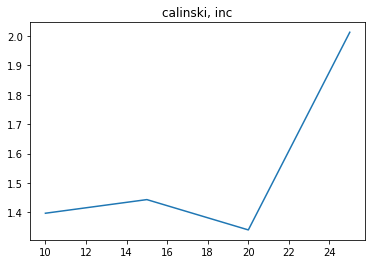

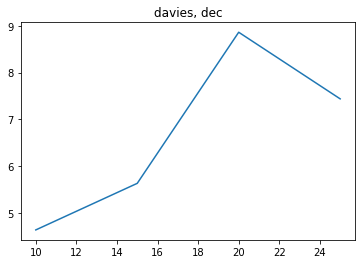

In [23]:
# Оценка оптимального количества кластеров
MIN_I=10
MAX_I=30
N_STEP = 5
def count_metrics(data, i):    
    print(i)
    try:
        brc3 = SpectralClustering(i, n_init=5, assign_labels='discretize')
        preds3 = brc3.fit_predict(data)
        return [metrics.calinski_harabasz_score(data, preds3), metrics.davies_bouldin_score(data, preds3)]
    except:
        return[-1,-1]


counted = np.array([count_metrics(df_num, i) for i in range(MIN_I, MAX_I, N_STEP)])
plt.plot(range(MIN_I,MAX_I, N_STEP), counted[:,0])
plt.title('calinski, inc')
plt.show()
plt.plot(range(MIN_I,MAX_I, N_STEP), counted[:,1])      
plt.title('davies, dec')
plt.show()

In [27]:
brc = SpectralClustering(35, n_init=5,
                         assign_labels='discretize',
                         affinity='nearest_neighbors',
                         random_state=0)

preds = brc.fit_predict(df_num)

In [35]:
res_cls = pd.DataFrame(preds, columns=['target'], index=df_num.index) 

In [36]:
res_cls.loc[res_cls.index.isin(black_list), 'target'].value_counts()

2     25
27    19
12    16
4     15
26    14
5     13
1     12
29    12
31    11
8     11
28    10
18    10
15    10
20     9
16     9
0      8
17     8
34     8
22     7
32     7
24     5
11     5
10     5
3      4
14     3
7      3
19     2
6      2
30     2
33     2
13     1
21     1
Name: target, dtype: int64

In [37]:
res_cls.loc[res_cls.index.isin(white_list), 'target'].value_counts()

32    6
16    6
25    6
22    5
30    3
6     2
27    2
29    1
Name: target, dtype: int64

In [ ]:
#Кластеризация на новых данных
res_upd = res_cls.copy().loc[res_cls.index.isin(data_upd.id)]

In [ ]:
res_upd.loc[:, 0].value_counts()

In [ ]:
#Загрузка информации на сервер
for idx, row in res_upd.iterrows():
    result = requests.post('https://slot-ml.com/api/v1/users/4e5bd33034c6cf34acd47a679ed113f367c21d1c/results/',
                       data={ "vector": idx, "class": row.loc[0] })        
    print(result.json())

### День шестой: streamlit


Оставшееся время имеет смысл потратить на оформление рабочего приложения. Интерфейс, для скорости, будет построен с использованием streamlit. Сам код требует дальнейшей оптимизации и шлифовки. 

____________________

### Классификатор

In [ ]:
# Блок для активного обучения

# df['target'] = df['id'].apply(lambda x: 1 if x in black_list else 0 if x in white_list else-1)
# X_train, y_train = df.loc[df.target>-1, :].drop(columns=['target']), df.loc[df.target>-1, :].loc[:, 'target']
# X_test = df.loc[df.target==-1, :].drop(columns=['target'])

In [58]:
df_cls = data.copy()
prepr = Preprocessor()

In [60]:
X_train, X_test, y_train, y_test= train_test_split(df_cls.sort_values('id'), res_cls['target'].sort_index())

X_train = prepr.fit_transform(X_train)
X_test = prepr.transform(X_test)

In [72]:
clf = RandomForestClassifier(max_depth=3, n_estimators=10, random_state=0)
clf.fit(X_train.set_index('id').select_dtypes(include=[np.number]), y_train)

preds = clf.predict_proba(X_test.set_index('id').select_dtypes(include=[np.number]))
res = pd.DataFrame(preds, index=X_test.id)

In [73]:
res.max(axis=1)

id
083b79f2c0118555d1ea4d34195c5edf    0.166122
d38dc98b5d0d06600a67877e5f3c5c93    0.087626
4433e37018de53fb462b84d8b492c425    0.083753
4ced43777d99a84e37091c48f4980890    0.140889
860a0db4970eedf4b35b7ccf4ada077d    0.165257
                                      ...   
4929cc72a38f645994ef374c028a21bb    0.081244
9114dc20b0c3b391cc3353393b08ff31    0.087626
359f0268bb90a396619f1ec15c401b8d    0.167681
b17ea7f67785d036e7c68c04f7c442fe    0.127206
7a9b1823ed970263cf6d01a1f800373f    0.384707
Length: 160, dtype: float64

In [74]:
res.idxmax(axis=1)

id
083b79f2c0118555d1ea4d34195c5edf    18
d38dc98b5d0d06600a67877e5f3c5c93    31
4433e37018de53fb462b84d8b492c425    31
4ced43777d99a84e37091c48f4980890    29
860a0db4970eedf4b35b7ccf4ada077d    29
                                    ..
4929cc72a38f645994ef374c028a21bb    31
9114dc20b0c3b391cc3353393b08ff31    31
359f0268bb90a396619f1ec15c401b8d    29
b17ea7f67785d036e7c68c04f7c442fe    32
7a9b1823ed970263cf6d01a1f800373f     2
Length: 160, dtype: int64

______________________________________
### Выгрузки

In [ ]:
send_classes_and_print_stats(black_list, 1)

In [ ]:
get_stats()

In [ ]:
data_upd_test = prepr.transform(data_upd)

In [ ]:
preds = clf.predict_proba(data_upd_test.set_index('id').select_dtypes(include=[np.number]))
res = pd.DataFrame(preds, columns=[0,1], index=data_upd_test.id)

In [ ]:
send_classes_and_print_stats(res[res[1]>0.8].index.tolist(), 1)

In [ ]:
get_stats()

______________________________